In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

from tqdm import tqdm
import glob
from PIL import Image

### **Google Drive linking and other operations for saving some data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
PATH_DRIVE = '/content/drive/My Drive/Colab Notebooks/Corso_ML/GANs/' # Path on Google Drive where to save data (trained models and generation samples)

Mounted at /content/drive


In [3]:
verbose = False
torch.manual_seed(1)
NOISE_VECTOR_DIM = 100
MODEL_NAME = 'VanillalGAN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### **Dataset loading and preparation**

In [4]:
#MNIST dataset preparation
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
                              )

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
batch_size = 64
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.87MB/s]


**Leaky ReLU and Batch Normalization**
<hr>

**Leaky ReLU** is a type of activation function that helps to prevent the function from becoming saturated at 0. It has a small slope instead of the standard ReLU which has an infinite slope. <br>
Leaky ReLU is a modification of the ReLU activation function. It has the same form as the ReLU, but it will leak some positive values to 0 if they are close enough to zero. It uses leaky values to avoid dividing by zero when the input value is negative, which can happen with standard ReLU when training neural networks with gradient descent.
<hr>

**Batch normalization** (also known as batch norm) is a method used to make training of artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling.

In [5]:
class Generator(nn.Module):
  '''
  Generator model definition.
  In the Vanilla GAN it is defined as an MLP model with input size equal to noise vector.
  The output size is the same as images we want to generate.
  '''
  def __init__(self, input_size=NOISE_VECTOR_DIM, output_size=784):
    super(Generator, self).__init__()

    # Build a model by composing fully connected layers using nn.Linear(dim1, dim2).
    # Transform the data through several layers (4 or 5) to achieve the correct final dimension.
    # Which activation function is best to use with data in the range [-1, 1]?
    # Use nn.ACTIVATION_NAME(parameters if needed).
    # Also apply batch normalization to regularize the data with
    # nn.BatchNorm1d(dim), where dim = dim2 of the previous layer.
    # Where is it better to place the batch normalization layers: before or after the activation function?
    # Since the data is in the range [-1, 1], what is the best choice for the activation function in the output layer?

    self.model = nn.Sequential(
    ...
    )

     # apply the model
    # reshape the data with the view function view(batch_size,#channels,dim1,dim2)

  def forward(self, noise_vector):
  ...
    return generated_img

In [6]:
class Discriminator(nn.Module):
  '''
  Discriminator model definition as a binary classifier.
  In the Vanilla GAN it is defined as an MLP model with input size equal to
  flattened image size.
  The output size is the 1 (i.e. the probability of a binary problem -> real or fake).
  '''
  def __init__(self, input_size=784, num_classes=1):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(input_size, 512),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Linear(256, num_classes),
      nn.Sigmoid(), #The final layer has the sigmoid activation function,
                    #which squashes the output value between 0 (fake) and 1 (real).
      )


  def forward(self, image):
    image_flattened = image.view(image.size(0), -1) #-1 tells PyTorch to flatten all the remaining dimensions (in this case 1, 28, 28) into a single dimension.
    result = self.model(image_flattened)
    return result

## **Training phase**

In [7]:
#Models creation
num_samples = 100
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

#Loss function
adversarial_loss  = nn.BCELoss() #Binary Cross Entropy Loss

#Optimizer
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [8]:
max_epoch = 2 # epochs for training; 2 epochs are not enough to obtain good results; try with 200 (about 1 hour training)
step = 0
step_frequency = 10000 #frequency to save training samples in order to see G's improvements
n_critic = 1 # for training more k steps about Discriminator

D_loss_history = []
G_loss_history = []

D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

for epoch in tqdm(range(max_epoch), desc='GAN training'):  # Loop over epochs with a progress bar for better training visualization
  for idx, (real_images, _) in enumerate(data_loader):  # you can use tqdm also in the internal loop if you want view the progress inside each epoch

    # Training Discriminator

    # Discriminator forward pass for real data and loss computation
    ...

    # sample a noise vector from a normal distribution, apply generator
    # discriminator forward pass for generated data and loss computation
    ...

    D.zero_grad() # it delete the gradients accumulated during the training in the previous batch
                  # the training needs to start (in the current batch) with zeroed gradients
    D_loss.backward()  #gradient computation
    D_optimizer.step() #weigth updates

    # Training Generator

    if step % n_critic == 0:  #n_critic=1 means the Generator will be trained at every step, right after the Discriminator
      z = torch.randn(batch_size, NOISE_VECTOR_DIM).to(DEVICE)
      z_outputs = D(G(z))
      G_loss = ... #loss function for the generator

      G.zero_grad()
      G_loss.backward()
      G_optimizer.step()

    if verbose:
      if step % 500 == 0:
        print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

    G.train()  # swap in training mode; it ensures that G remains in training mode for the next batch.
    step += 1

  D_loss_history.append(D_loss.item())
  G_loss_history.append(G_loss.item())

  torch.save(G.state_dict(), PATH_DRIVE + '/models/Discriminator/G_epoch_%d.pth' % (epoch))
  torch.save(D.state_dict(), PATH_DRIVE + '/models/Generator/D_epoch_%d.pth' % (epoch))

GAN training: 100%|██████████| 2/2 [02:23<00:00, 71.67s/it]


### **Plotting Generator and Discriminator's losses**

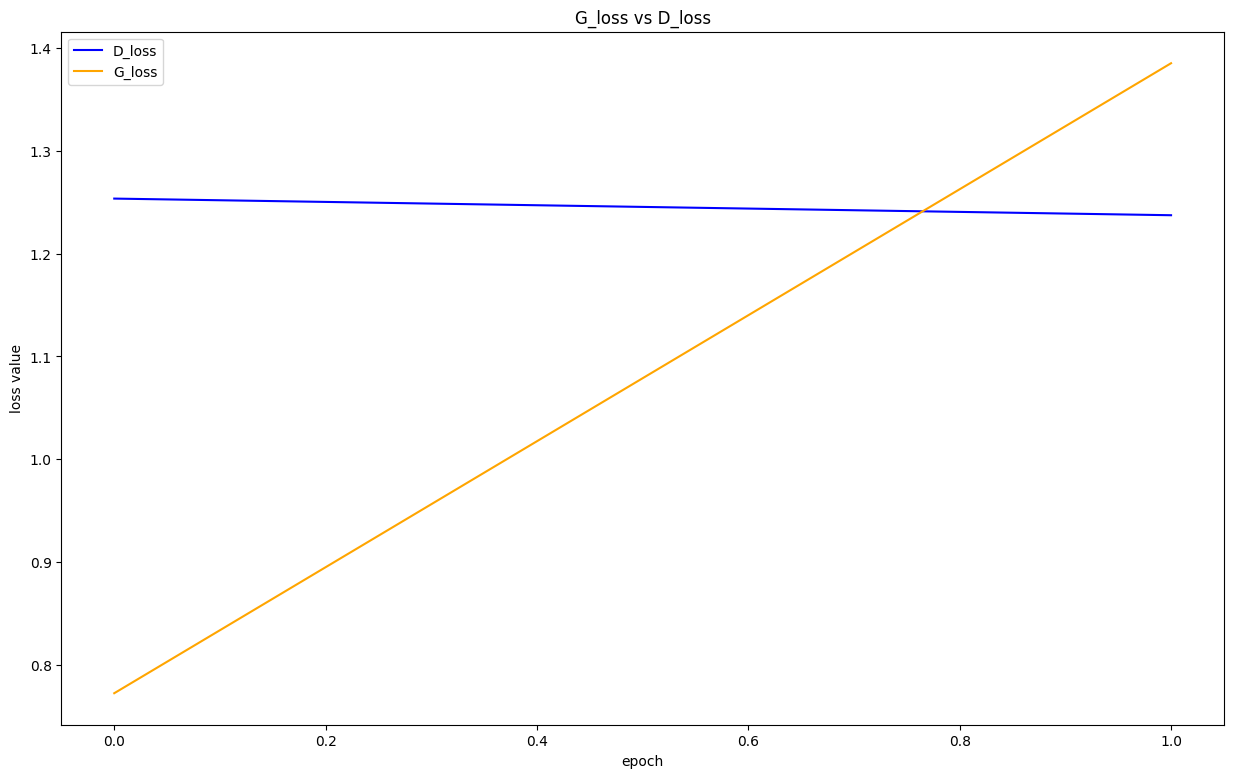

In [9]:
plt.figure(figsize=(15,9))
plt.plot(D_loss_history, color='blue', label='D_loss') #plot the data
plt.plot(G_loss_history, color='orange', label='G_loss') #plot the data
plt.ylabel('loss value') #set the label for y axis
plt.xlabel('epoch') #set the label for x-axis
plt.title("G_loss vs D_loss") #set the title of the graph
plt.legend()
plt.show() #display the graph

In [10]:
#to see at which epoch the Generator has te lowest loss
min_value = min(G_loss_history)
min_index = G_loss_history.index(min_value)
print(min_index)  #to see at which epoch the Generator has te lowest loss

# Saving models at last epoch of training
torch.save(D.state_dict(), PATH_DRIVE + '/models/Discriminator/Discriminator.pth')
torch.save(G.state_dict(), PATH_DRIVE + '/models/Generator/Generator.pth')

0


## **Post training operations**

### **Loading model using pytorch**

In [11]:
#Models creation
num_samples = 100
G = Generator().to(DEVICE)
G.load_state_dict(torch.load(PATH_DRIVE + 'models/Generator/Generator.pth'), strict=False)
#G.load_state_dict(torch.load(PATH_DRIVE + 'trained_models/Generator.pth'), strict=False)

print(G.eval()) #switch the generator to eval phase and print the model

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)


### **Generating Samples**

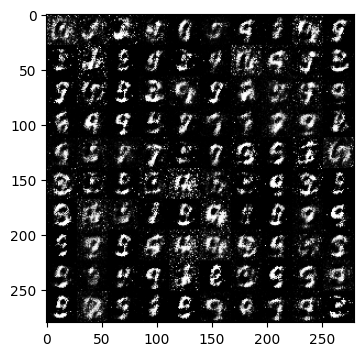

In [12]:
torch.manual_seed(1)

NOISE_VECTOR_DIM = 100

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_sample_images(G, num_samples):
    '''
    Generate num_samples noise vector from latent space and pass to Generator
    as input in order to get sample images.

    returns:
    num_samples generate images
    '''
    assert int(np.sqrt(num_samples)) * int(np.sqrt(num_samples)) == num_samples  , "num_samples square is not integer"
    #if num_samples is not a perfect square, the program will stop with an AssertionError exception.

    z = torch.randn(num_samples, NOISE_VECTOR_DIM).to(DEVICE)  #z.shape = torch.Size([num_samples, 100])
    y_hat = G(z).view(num_samples, 28, 28) # (100, 28, 28)
    samples_img = y_hat.cpu().data.numpy() # Since y_hat is computed by the neural network G,
                                           # it is not just a simple array of values, but an object with an associated
                                           #computational graph. We access the data attribute to obtain only the
                                           #generated data, which is needed for visualization

    #Put generated samples in a matrix of size sqrt(num_samples) x sqrt(num_samples)
    #in order to plot all samples togheter
    samples_per_line = int(np.sqrt(num_samples))
    matrix_img = np.zeros([28 * samples_per_line, 28 * samples_per_line])
    for j in range(samples_per_line):
        matrix_img[j*28:(j+1)*28] = np.concatenate([x for x in samples_img[j*samples_per_line:(j+1)*samples_per_line]], axis=-1)

    return matrix_img



# generation to image
plt.figure(figsize=(7, 4))
plt.imshow(get_sample_images(G, num_samples), cmap='gray')
plt.show()